## Importing the Required Libraries

In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob
# split data into train and test
from sklearn.model_selection import train_test_split
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models
# SVM classifier from scikit learn
from sklearn.svm import LinearSVC

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.preprocessing import StandardScaler, MinMaxScaler



%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Preparing the Data

In [2]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [3]:
stopwords = stopwords.words("english")

In [4]:
print (stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
filename  = '../Eng-Hin-data/english-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']
orig_df['Text'].head()

0    '@Cricket_Mann And they will see more of it no...
1    "Juma'at Kareem to all my Muslim brother aroun...
2    'Thorpe becomes England head coach for Pakista...
3    '@ParZevil Plymouth Cricket. THREE transmissions.
4    'jungkook didnâ€™t get caught eating food duri...
Name: Text, dtype: object

In [6]:
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)
df = orig_df

In [7]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [8]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [9]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

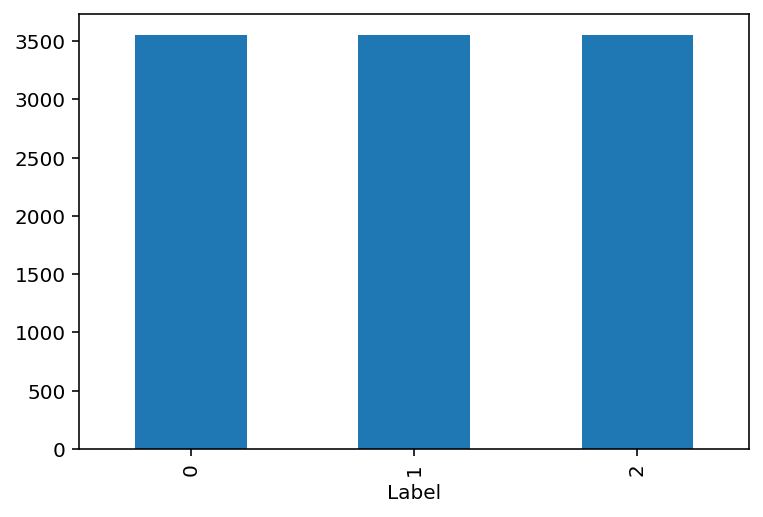

In [10]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [11]:
data=data.sample(frac=1).reset_index(drop=True)

In [12]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [13]:
import re
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [14]:
data.head()

,Text,Label
0,jaq577 khanumarfa chaandspeaks Attack from wh...,2
1,wiplayers But it is showing a rain forecast f...,0
2,Happy Muharram to all Muslim Let go the past ...,1
3,MilesKing10 townsendoutdoor First they came f...,0
4,Need more cricket watchalong like these tbf f...,0


In [15]:
print(len(data))

10663


In [16]:
# data = orig_df['Text']

data['Text'].head()

0     jaq577 khanumarfa chaandspeaks Attack from wh...
1     wiplayers But it is showing a rain forecast f...
2     Happy Muharram to all Muslim Let go the past ...
3     MilesKing10 townsendoutdoor First they came f...
4     Need more cricket watchalong like these tbf f...
Name: Text, dtype: object

In [17]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data['Text'])

In [18]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['khanumarfa', 'chaandspeak', 'mob', 'say', 'be', 'islami', 'brainless', 'mob']


In [19]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['khanumarfa', 'chaandspeak', 'mob', 'say', 'be', 'islami', 'brainless', 'mob']


In [20]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


In [21]:
len(corpus)

10663

In [260]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
#                                            id2word=id2word,
#                                            num_topics=15,
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=50,
#                                            alpha="auto")

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=15,
                                           chunksize=100,
                                           workers=7, # Num. Processing Cores - 1
                                           passes=50,
                                           eval_every = 1,
                                           per_word_topics=True)

In [261]:
lda_model.save("test_model.model")

In [262]:
new_model = gensim.models.ldamodel.LdaModel.load("test_model.model")

In [263]:
train_vecs = []
for i in range(len(data)):
    top_topics = new_model.get_document_topics(corpus[i][:-1], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(15)]
    topic_vec.extend([len(data.iloc[i].Text)]) # length review
    train_vecs.append(topic_vec)

In [264]:
train_vecs[2]

[0.008333949,
 0.008333953,
 0.008333949,
 0.008333949,
 0.008333949,
 0.008333949,
 0.008333949,
 0.008333972,
 0.008333953,
 0.008333957,
 0.008333953,
 0.8833246,
 0.008333949,
 0.008333949,
 0.008333949,
 120]

In [265]:
# Using similar split 90/10
X = np.array(train_vecs)
y = np.array(data.Label)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, data.index, test_size=0.30, random_state=100)

In [266]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [267]:
model2 = LinearSVC(random_state=10, tol=1e-5, verbose=1, max_iter=100000)
model2.fit(X_train_scale, y_train)
y_pred2 = model2.predict(X_test_scale)

[LibLinear]

In [268]:
results2 = confusion_matrix(y_test, y_pred2)
print ('Confusion Matrix :')
print(results2)
print ('Accuracy Score :',accuracy_score(y_test, y_pred2))
print ('Report : ')
print (classification_report(y_test, y_pred2))

Confusion Matrix :
[[685 208 181]
 [119 812 145]
 [141 164 744]]
Accuracy Score : 0.7005314160675211
Report : 
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1074
           1       0.69      0.75      0.72      1076
           2       0.70      0.71      0.70      1049

    accuracy                           0.70      3199
   macro avg       0.70      0.70      0.70      3199
weighted avg       0.70      0.70      0.70      3199



In [269]:
# test_doc = corpus[-1]

# vector = new_model[test_doc]
# print (vector)
# For topic importance
# def Sort(sub_li):
#     sub_li.sort(key = lambda x: x[1])
#     sub_li.reverse()
#     return (sub_li)
# new_vector = Sort(vector)
# print (new_vector)

## Vizualizing the Data

In [270]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.226773  0.094848       1        1  11.362920
8     -0.348447  0.083224       2        1  10.296882
12    -0.269453 -0.243997       3        1   9.805986
0     -0.092376 -0.335918       4        1   8.682082
5     -0.083223 -0.161492       5        1   6.924653
14     0.192060 -0.392039       6        1   6.592282
2      0.120212  0.328777       7        1   6.560797
4     -0.325987 -0.078287       8        1   6.490313
13     0.025729  0.007716       9        1   5.355444
11    -0.195656  0.269945      10        1   5.326820
3     -0.042611  0.385008      11        1   5.151198
7      0.265061 -0.052481      12        1   4.727810
1      0.320820 -0.202608      13        1   4.374700
6      0.395756  0.068296      14        1   4.230281
10     0.264888  0.229007      15        1   4.117831, topic_info=                 Term         Freq        Total Category  logprob  loglift
18                 ðy  1508.000000  1508.000000  Default  30.0000  30.0000
7             cricket  1808.000000  1808.000000  Default  29.0000  29.0000
176            muslim  1895.000000  1895.000000  Default  28.0000  28.0000
79               year   846.000000   846.000000  Default  27.0000  27.0000
104         terrorist  1109.000000  1109.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1400  realdonaldtrump    20.914107    42.685456  Topic15  -4.9424   2.4764
210              find    23.991451    66.972091  Topic15  -4.8051   2.1633
0                  be    39.665331  5048.448971  Topic15  -4.3024  -1.6565
1483           letter    18.410292    36.176586  Topic15  -5.0699   2.5143
167                do    20.724034   674.677994  Topic15  -4.9515  -0.2931

[742 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2302      1  0.948705        able
1861      3  0.960207  absolutely
1809      6  0.960380       abuse
928       9  0.976424      accept
2317      2  0.962358      accord
...     ...       ...         ...
2393      6  0.956724         ðys
2392      6  0.917994     ðyz_ðyz
2138     15  0.971664         ðyœ
287      15  0.894266     ðyœ_ðyœ
865      15  0.945633         œðy

[990 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 13, 1, 6, 15, 3, 5, 14, 12, 4, 8, 2, 7, 11])